In [2]:
import os
from tqdm import tqdm
from IPython.display import clear_output
import random
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

%load_ext autoreload
%autoreload 2
import helper
import sys
if "helper" in sys.modules:
    del sys.modules["helper"]

spring_months = helper.spring_months
fall_months = helper.fall_months
print(f"Spring months: {spring_months}"
      f"\nFall months: {fall_months}")

Spring months: [2, 3, 4, 5]
Fall months: [9, 10, 11]


In [3]:
weeks_dir = r'D:\OneDrive_Emory\OneDrive - Emory\Research_doc\hourly_population\ranked_weeks_CSV_v2'
all_days_files = glob(os.path.join(weeks_dir, '*_days.csv'))
print(f'Total day files found: {len(all_days_files)}')
all_days_files.sort()

Total day files found: 13577


In [4]:
# get all county FIPS codes
all_county_fips = [os.path.basename(f).split('_')[2] for f in all_days_files]
files_df = pd.DataFrame({'day_file_path': all_days_files, 'county_fips': all_county_fips})
files_df['week_file_name'] = files_df['day_file_path'].str.replace("_days.csv", ".csv")
all_county_fips = files_df['county_fips'].unique().tolist()
print(f'Total unique county FIPS found: {len(all_county_fips)}') 

files_df


Total unique county FIPS found: 2678


,day_file_path,county_fips,week_file_name
0,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,01001,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
1,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,01001,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
2,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,01001,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
3,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,01001,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
4,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,01003,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
...,...,...,...
13572,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,56037,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
13573,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,56039,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
13574,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,56041,D:\OneDrive_Emory\OneDrive - Emory\Research_do...
13575,D:\OneDrive_Emory\OneDrive - Emory\Research_do...,56043,D:\OneDrive_Emory\OneDrive - Emory\Research_do...


In [ ]:
# has bugs, cleaning bugs!!!!!!!!!!!!!!!!!!!

noon_visit_80quantile_thres = 30
save_path = r'D:\OneDrive_Emory\OneDrive - Emory\Research_doc\hourly_population\county_visit_scaling_factors_monthly'
os.makedirs(save_path, exist_ok=True)

  

county_school_month_df_list = []
for county_fips in tqdm(all_county_fips, total=len(all_county_fips)):
    # county_fips = '01001'  # 2022-04-11 week has issues. high visit_scaling_factor > 5 due to less school data
    # county_fips = random.choice(all_county_fips)
    # county_fips = '18071'
    # county_fips = '12045'  # test case
    # county_fips = random.choice(all_county_fips)
    # county_fips = '48013'
    
    week_files = files_df.query(f"county_fips == '{county_fips}'")['week_file_name'].tolist()
    day_files = files_df.query(f"county_fips == '{county_fips}'")['day_file_path'].tolist()

    if len(week_files) == 0 or len(day_files) == 0:
        print(f'No data found for county FIPS: {county_fips}, skipping...')
        continue

    week_files.sort()
    day_files.sort()



    # print("Processing county FIPS:", county_fips)
    # print("Found week files:", len(week_files))
    
    df_list = []
    school_name_list = []
    for f in day_files:
        day_df = pd.read_csv(f).query("is_school_day == True")
        ranked_week_df = pd.read_csv(f.replace("_days.csv", ".csv"))
        ranked_week_df['county_FIPS'] = ranked_week_df['county_FIPS'].astype(str).str.zfill(5)     
        ranked_week_df['weekly_raw_visitor_counts'] = ranked_week_df['weekly_raw_visitor_counts'].astype(int)
        ranked_week_df['noon_visit_80quantile'] = ranked_week_df['noon_visit_80quantile'].astype(int)
        ranked_week_df = ranked_week_df.query(f"noon_visit_80quantile >= {noon_visit_80quantile_thres}")
        date_range_starts = ranked_week_df['date_range_start'].unique().tolist()
        day_df = day_df[day_df['date_range_start'].isin(date_range_starts)]
        day_df = day_df.merge(ranked_week_df[['week_start_year', 'week', 'date_range_start', 'date_range_end', 'placekey', 'school_name', 'county_FIPS', 'county_name', 'State_name']], on=['week_start_year', 'week', 'date_range_start', 'date_range_end' ], how='inner')
        
        

        if len(day_df) > 0:            
            df_list.append(day_df)
            school_name = day_df['school_name'].unique()[0]
            school_name_list.append(school_name)
        # break
 
    if len(df_list) == 0:
        print(f'No valid school day data for county FIPS: {county_fips}, skipping...')
        continue

    county_school_day_df = pd.concat(df_list, ignore_index=True)
    county_school_day_df['year'] = pd.to_datetime(county_school_day_df['date']).dt.year
    county_school_day_df['month'] = pd.to_datetime(county_school_day_df['date']).dt.month
    
    county_school_month_df = county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=('noon_visit_80quantile', 'sum'),
                                                                                    raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
                                                                                    schoolday_count=('date', 'count'),
                                                                                    ).reset_index()
    county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
    county_school_month_df['visit_scaling_factor'] = county_school_month_df['visit_scaling_factor'].round(3)
    state_name = county_school_day_df['State_name'].unique()[0]
    county_name = county_school_day_df['county_name'].unique()[0]
    county_school_month_df['school_count'] = len(school_name_list)
    county_school_month_df['state_name'] = state_name
    county_school_month_df['county_name'] = county_name
    county_school_month_df['county_fips'] = county_fips
    county_school_month_df['school_names'] = ', '.join(school_name_list)
    county_school_month_df_list.append(county_school_month_df)  
    # fname = os.path.join(save_path, f'{county_fips}_{state_name}_{county_name}_visit_scaling_factors_monthly.csv')
    # county_school_month_df.to_csv(fname, index=False)   

    # break
fname = os.path.join(save_path, f'all_counties_visit_scaling_factors_monthly.csv')
all_county_school_month_df = pd.concat(county_school_month_df_list, ignore_index=True)
all_county_school_month_df.to_csv(fname, index=False)

# day_files
# day_df
# county_school_day_df.sort_values(by=['date']).query("week == 9")
# county_school_day_df.groupby(['year', 'month']).agg(schoolday_count=('date', 'count')).reset_index()
# county_school_month_df
all_county_school_month_df

## Process the k for all counties, all months

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [708]:
raw_fname = r"D:\OneDrive_Emory\OneDrive - Emory\Research_doc\hourly_population\county_visit_scaling_factors_monthly\all_counties_visit_scaling_factors_monthly.csv"
all_county_school_month_df = pd.read_csv(raw_fname, dtype={'county_fips': str})
all_county_school_month_df


,year,month,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,county_fips,school_names
0,2022,1,1084,2954,13,2.725,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury..."
1,2022,2,3029,8717,43,2.878,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury..."
2,2022,3,5362,13997,58,2.610,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury..."
3,2022,4,5208,14596,60,2.803,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury..."
4,2022,5,3505,10245,40,2.923,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury..."
...,...,...,...,...,...,...,...,...,...,...,...
23414,2022,10,150,305,5,2.033,1,Wyoming,Washakie,56043,Worland High School
23415,2022,11,160,410,5,2.562,1,Wyoming,Washakie,56043,Worland High School
23416,2022,2,33,94,1,2.848,1,Wyoming,Weston,56045,Newcastle High School
23417,2022,3,375,1018,11,2.715,1,Wyoming,Weston,56045,Newcastle High School


In [547]:
# load all US counties
import geopandas as gpd
county_gdf = gpd.read_file(r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_county_20m.zip')
county_gdf = county_gdf.rename(columns={'NAME': 'county_name', 'GEOID': 'county_fips'})
county_gdf

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,county_fips,county_name,LSAD,ALAND,AWATER,geometry
0,29,227,00758566,0500000US29227,29227,Worth,06,690564983,493903,"POLYGON ((-94.63203 40.57176, -94.53388 40.570..."
1,31,061,00835852,0500000US31061,31061,Franklin,06,1491355860,487899,"POLYGON ((-99.1794 40.35068, -98.72683 40.3504..."
2,36,013,00974105,0500000US36013,36013,Chautauqua,06,2746047476,1139407865,"POLYGON ((-79.76195 42.26986, -79.62748 42.324..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653713542,42178610,"POLYGON ((-78.49773 36.51467, -78.45728 36.541..."
4,47,183,01639799,0500000US47183,47183,Weakley,06,1503107848,3707114,"POLYGON ((-88.94916 36.4101, -88.81642 36.4107..."
...,...,...,...,...,...,...,...,...,...,...
3215,40,091,01101836,0500000US40091,40091,McIntosh,06,1601359179,242867678,"POLYGON ((-95.98151 35.28978, -95.98146 35.376..."
3216,40,095,01101832,0500000US40095,40095,Marshall,06,962443215,143430766,"POLYGON ((-96.96842 34.17268, -96.9335 34.1727..."
3217,48,225,01383898,0500000US48225,48225,Houston,06,3188278910,14435337,"POLYGON ((-95.7287 31.16406, -95.72523 31.2710..."
3218,48,407,01383989,0500000US48407,48407,San Jacinto,06,1474332268,151949233,"POLYGON ((-95.32748 30.85955, -95.25238 30.906..."


In [1323]:
# ! pip install -U ipykernel

In [1503]:
def visualize_county_data(county_fips, refined_county_school_month_df):
    county_df = refined_county_school_month_df.query(f"county_fips == '{county_fips}'")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(county_df['month'], county_df['state_visit_scaling_factor'], label='state_visit_scaling_factor')
    ax.plot(county_df['month'], county_df['visit_scaling_factor'], label='visit_scaling_factor', linestyle='--')
    ax.set_xlabel('Month')
    ax.set_ylabel('Visit Scaling Factor')
    county_name = county_df['county_name'].iloc[0]
    state_name = county_df['state_name'].iloc[0]
    ax.set_title(f'Visit Scaling Factor Over Months for {county_name}, {state_name} (FIPS: {county_fips})')
    ax.set_xticks(range(1, 13))
    ax.grid(True)
    ax.legend()
    plt.show()
    return county_df

  3%|▎         | 98/3220 [00:01<00:40, 76.67it/s]C:\tmp\ipykernel_10884\912659800.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '317490.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  county_df.loc[county_df['month'] == 7, field] = (month_5_value + month_9_value)/2
  6%|▌         | 182/3220 [00:02<00:23, 131.19it/s]C:\tmp\ipykernel_10884\912659800.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '55218.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  county_df.loc[county_df['month'] == 7, field] = (month_5_value + month_9_value)/2
  7%|▋         | 212/3220 [00:02<00:21, 138.86it/s]C:\tmp\ipykernel_10884\912659800.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version

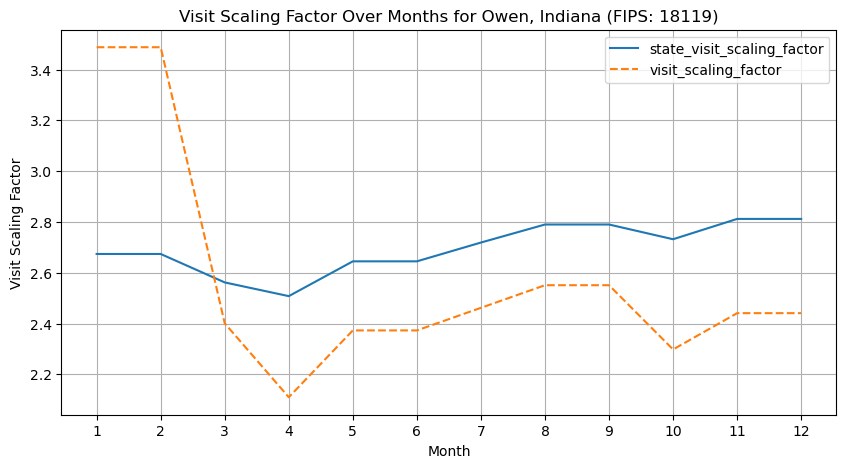

,county_fips,month,year,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,school_names,state_fips,state_raw_visitor_counts,state_noon_visit_80quantile,state_visit_scaling_factor
9072,18119,1,2022,420.0,1465.0,9.0,3.488,1.0,Indiana,Owen,Owen Valley Community Hs,18,376335.0,140714.0,2.674
9073,18119,2,2022,420.0,1465.0,5.0,3.488,1.0,Indiana,Owen,Owen Valley Community Hs,18,376335.0,140714.0,2.674
9074,18119,3,2022,1576.0,3784.0,14.0,2.401,1.0,Indiana,Owen,Owen Valley Community Hs,18,986356.0,385004.0,2.562
9075,18119,4,2022,2624.0,5536.0,21.0,2.110,1.0,Indiana,Owen,Owen Valley Community Hs,18,1236298.0,492944.0,2.508
9076,18119,5,2022,1245.0,2955.0,10.0,2.373,1.0,Indiana,Owen,Owen Valley Community Hs,18,1146309.0,433318.0,2.645
9077,18119,6,2022,1245.0,2955.0,NaN,2.373,NaN,NaN,NaN,NaN,18,1146309.0,433318.0,2.645
9078,18119,7,2022,1989.5,4964.5,NaN,2.462,NaN,NaN,NaN,NaN,18,1195761.5,439754.5,2.719
9079,18119,8,2022,2734.0,6974.0,13.0,2.551,1.0,Indiana,Owen,Owen Valley Community Hs,18,1253061.0,449057.0,2.790
9080,18119,9,2022,2734.0,6974.0,21.0,2.551,1.0,Indiana,Owen,Owen Valley Community Hs,18,1253061.0,449057.0,2.790
9081,18119,10,2022,2228.0,5119.0,16.0,2.298,1.0,Indiana,Owen,Owen Valley Community Hs,18,1055605.0,386375.0,2.732


In [1768]:
# visualize a random county's data
import random
from tqdm import tqdm

def visualize_county_data(county_fips, refined_county_school_month_df):
    county_df = refined_county_school_month_df.query(f"county_fips == '{county_fips}'")
    county_df = county_df.sort_values(by=['month'])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(county_df['month'], county_df['state_visit_scaling_factor'], label='state_visit_scaling_factor')
    ax.plot(county_df['month'], county_df['visit_scaling_factor'], label='visit_scaling_factor', linestyle='--')
    ax.set_xlabel('Month')
    ax.set_ylabel('Visit Scaling Factor')
    county_name = county_df['county_name'].iloc[0]
    state_name = county_df['state_name'].iloc[0]
    ax.set_title(f'Visit Scaling Factor Over Months for {county_name}, {state_name} (FIPS: {county_fips})')
    ax.set_xticks(range(1, 13))
    ax.grid(True)
    ax.legend()
    plt.show()
    return county_df

def refine_county_data(all_county_school_month_df):

    all_county_school_month_df['state_fips'] = all_county_school_month_df['county_fips'].str[:2]
    all_county_fips = county_gdf['county_fips'].unique().tolist()
    all_county_fips = sorted(all_county_fips)
    # all_county_fips = ['46096']
    df_list = []

    # create a dataframe for each county with all months
    for county_fips in tqdm(all_county_fips, total=len(all_county_fips)):
        # if not county_fips.startswith('18'):
        #     continue
        county_df = pd.DataFrame(columns=["county_fips"])
        county_df['month'] = range(1, 13)
        county_df['county_fips'] = county_fips
        county_df['year'] = 2022
        
        df = all_county_school_month_df.query(f"county_fips == '{county_fips}'").copy()
        # print("df:\n", df)

        county_df = county_df.merge(df, on=['year', 'month', 'county_fips'], how='left')
        
        # print(df)
        for field in ['visit_scaling_factor', 'raw_visitor_counts', 'noon_visit_80quantile']:
            month_2_value = county_df.loc[county_df['month'] == 2, field].iloc[0]
            month_5_value = county_df.loc[county_df['month'] == 5, field].iloc[0]
            month_9_value = county_df.loc[county_df['month'] == 9, field].iloc[0]
            month_11_value = county_df.loc[county_df['month'] == 11, field].iloc[0]

            county_df.loc[county_df['month'] == 1, field] = month_2_value        
            county_df.loc[county_df['month'] == 6, field] = month_5_value
            county_df.loc[county_df['month'] == 8, field] = month_9_value
            county_df.loc[county_df['month'] == 7, field] = (month_5_value + month_9_value)/2
            county_df.loc[county_df['month'] == 12, field] = month_11_value
        

        df_list.append(county_df)    

        # break
    all_df = pd.concat(df_list, ignore_index=True)
    all_df['state_fips'] = all_df['county_fips'].str[:2]
    # print("county_df before compute state scaling factor:\n", all_df.query("county_fips == '18119'"))
    all_df['state_visit_scaling_factor'] = all_df.groupby(['year', 'month', 'state_fips'])['raw_visitor_counts'].transform('sum') / all_df.groupby(['year', 'month', 'state_fips'])['noon_visit_80quantile'].transform('sum')

    # print("county_df after compute state scaling factor:\n", all_df.query("county_fips == '18119'"))
    
    state_visit_scaling_factor_df = all_df.groupby(['year', 'month', 'state_fips'], as_index=False).agg(
                state_raw_visitor_counts=('raw_visitor_counts', 'sum'),
                state_noon_visit_80quantile=('noon_visit_80quantile', 'sum')
            )

    state_visit_scaling_factor_df['state_visit_scaling_factor'] = state_visit_scaling_factor_df['state_raw_visitor_counts'] / state_visit_scaling_factor_df['state_noon_visit_80quantile']

    # update all state_visit_scaling_factor for all counties
    df_list = []
    for county_fips in tqdm(all_county_fips, total=len(all_county_fips)):
        county_df = all_df.query(f"county_fips == '{county_fips}'").copy()
        county_df['state_fips'] = county_fips[:2]
        # if county_fips == '18119':
            # print("county_df:\n", county_df)
        county_df = county_df.drop(columns=['state_visit_scaling_factor']).merge(state_visit_scaling_factor_df, on=['year', 'month', 'state_fips'], how='left')

        # if the county visit_scaling_factor is nan, use the state visit_scaling_factor
        county_df['visit_scaling_factor'] = county_df['visit_scaling_factor'].fillna(county_df['state_visit_scaling_factor'])
        # if county_fips == '18119':
            # print("county_df:\n", county_df)
        df_list.append(county_df)

    refined_county_school_month_df = pd.concat(df_list, ignore_index=True)
    # state_visit_scaling_factor_df['state_fips'] = state_visit_scaling_factor_df['state_name'].str[:2]
    # print("state_visit_scaling_factor_df:\n", state_visit_scaling_factor_df)
    # delect nan rows of state_visit_scaling_factor
    # miss_df = all_df[all_df['state_visit_scaling_factor'].isna()].copy()
    # miss_df['state_fips'] = miss_df['county_fips'].copy().str[:2] 

    # print("miss_df:\n", miss_df)

    # df_list = []    
    # county_fips_list = miss_df['county_fips'].unique().tolist()
    # for county_fips in tqdm(county_fips_list, total=len(county_fips_list)):
    #     df = miss_df.query(f"county_fips == '{county_fips}'").drop(columns=['state_visit_scaling_factor']).copy()
    #     df['state_fips'] = county_fips[:2]
    #     df = df.merge(state_visit_scaling_factor_df, on=['year', 'month',  'state_fips'], how='left')
    #     # print("df:\n", df)
    #     df['visit_scaling_factor'] = df['state_visit_scaling_factor']
    #     df = df.drop(columns=['state_visit_scaling_factor'])
    #     df_list.append(df)
    # miss_df = pd.concat(df_list, ignore_index=True)
    # mask = all_df['state_visit_scaling_factor'].isna()
    # refined_county_school_month_df = pd.concat([all_df[~mask], miss_df], ignore_index=True)


    # all_df['visit_scaling_factor'] = all_df['visit_scaling_factor'].fillna(all_df['state_visit_scaling_factor'])
    refined_county_school_month_df['visit_scaling_factor'] = refined_county_school_month_df['visit_scaling_factor'].round(3)
    refined_county_school_month_df['state_visit_scaling_factor'] = refined_county_school_month_df['state_visit_scaling_factor'].round(3)

    return refined_county_school_month_df

all_county_school_month_df = pd.read_csv(raw_fname, dtype={'county_fips': str})
refined_county_school_month_df = refine_county_data(all_county_school_month_df)

all_county_fips = refined_county_school_month_df['county_fips'].unique().tolist()
county_fips = random.choice(all_county_fips)
county_fips = '18119'
visualize_county_data(county_fips, refined_county_school_month_df)



In [1767]:
save_dir = r"D:\OneDrive_Emory\OneDrive - Emory\Research_doc\hourly_population\hourly_results"
refined_county_school_month_df.to_csv(os.path.join(save_dir, 'refined_county_school_month_2022.csv'), index=False)

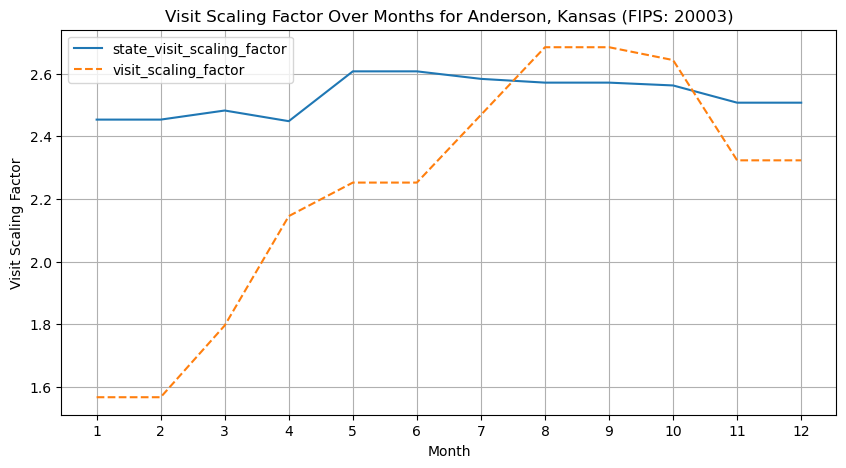

,county_fips,month,year,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,school_names,state_fips,state_raw_visitor_counts,state_noon_visit_80quantile,state_visit_scaling_factor
10668,20003,1,2022,60.0,94.0,8.0,1.567,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,103242.0,42090.0,2.453
10669,20003,2,2022,60.0,94.0,1.0,1.567,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,103242.0,42090.0,2.453
10670,20003,3,2022,560.0,1006.0,9.0,1.796,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,343144.0,138243.0,2.482
10671,20003,4,2022,1257.0,2696.0,19.0,2.145,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,502473.0,205271.0,2.448
10672,20003,5,2022,695.0,1565.0,10.0,2.252,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,332217.0,127456.0,2.607
10673,20003,6,2022,695.0,1565.0,NaN,2.252,NaN,NaN,NaN,NaN,20,332217.0,127456.0,2.607
10674,20003,7,2022,404.5,935.5,NaN,2.468,NaN,NaN,NaN,NaN,20,399953.5,154851.5,2.583
10675,20003,8,2022,114.0,306.0,8.0,2.684,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,480750.0,186974.0,2.571
10676,20003,9,2022,114.0,306.0,2.0,2.684,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,480750.0,186974.0,2.571
10677,20003,10,2022,255.0,674.0,5.0,2.643,1.0,Kansas,Anderson,Anderson County Jr Sr High School,20,445607.0,173929.0,2.562


In [1793]:
county_fips = random.choice(all_county_fips)
visualize_county_data(county_fips, refined_county_school_month_df)
 

In [1794]:
national_state_visit_scaling_factor_df = state_visit_scaling_factor_df.groupby(['year', 'month']).agg(national_raw_visitor_counts=('state_raw_visitor_counts', 'sum'), national_noon_visit_80quantile=('state_noon_visit_80quantile', 'sum')).reset_index()
national_state_visit_scaling_factor_df['national_visit_scaling_factor'] = national_state_visit_scaling_factor_df['national_raw_visitor_counts'] / national_state_visit_scaling_factor_df['national_noon_visit_80quantile']
print("national_state_visit_scaling_factor mean:\n", national_state_visit_scaling_factor_df['national_visit_scaling_factor'].mean())
national_state_visit_scaling_factor_df

national_state_visit_scaling_factor mean:
 2.6573388438692316


,year,month,national_raw_visitor_counts,national_noon_visit_80quantile,national_visit_scaling_factor
0,2022,1,20961841.0,8081270.0,2.593880
1,2022,2,20961841.0,8081270.0,2.593880
2,2022,3,37805777.0,15122835.0,2.499913
3,2022,4,37243202.0,14903511.0,2.498955
4,2022,5,38455945.0,14481321.0,2.655555
5,2022,6,38455945.0,14481321.0,2.655555
6,2022,7,40084384.5,14834750.5,2.702060
7,2022,8,41963469.0,15272286.0,2.747687
8,2022,9,41963469.0,15272286.0,2.747687
9,2022,10,41272527.0,14997671.0,2.751929


In [719]:
all_county_school_month_df = pd.read_csv(raw_fname, dtype={'county_fips': str})

all_county_school_month_df.query(f"county_fips == '{county_fips}'")

,year,month,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,county_fips,school_names


In [1795]:
all_county_school_month_df.query(f"state_name == 'Alabama' and month == 7")

,year,month,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,county_fips,school_names,state_fips
500,2022,7,168,516,4,3.071,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",01


# Create a CBG level stop scaling factor table

In [1798]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [1801]:
save_dir = r"D:\OneDrive_Emory\OneDrive - Emory\Research_doc\hourly_population\hourly_results"
refined_county_school_month_df = pd.read_csv(os.path.join(save_dir, 'refined_county_school_month_2022.csv'), dtype={'county_fips': str, 'state_fips': str})
refined_county_school_month_df['visit_scaling_factor'] = refined_county_school_month_df['visit_scaling_factor'].astype(float)
refined_county_school_month_df

,county_fips,month,year,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,school_names,state_fips,state_raw_visitor_counts,state_noon_visit_80quantile,state_visit_scaling_factor
0,01001,1,2022,3029.0,8717.0,13.0,2.878,4.0,Alabama,Autauga,"Autauga Academy, Billingsley High Sch, Marbury...",01,731033.0,266875.0,2.739234
1,01001,2,2022,3029.0,8717.0,43.0,2.878,4.0,Alabama,Autauga,"Autauga Academy, Billingsley High Sch, Marbury...",01,731033.0,266875.0,2.739234
2,01001,3,2022,5362.0,13997.0,58.0,2.610,4.0,Alabama,Autauga,"Autauga Academy, Billingsley High Sch, Marbury...",01,984506.0,360146.0,2.733630
3,01001,4,2022,5208.0,14596.0,60.0,2.803,4.0,Alabama,Autauga,"Autauga Academy, Billingsley High Sch, Marbury...",01,1076715.0,395058.0,2.725461
4,01001,5,2022,3505.0,10245.0,40.0,2.923,4.0,Alabama,Autauga,"Autauga Academy, Billingsley High Sch, Marbury...",01,829462.0,272194.0,3.047319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,72153,8,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0.0,0.0,NaN
38636,72153,9,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0.0,0.0,NaN
38637,72153,10,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0.0,0.0,NaN
38638,72153,11,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,0.0,0.0,NaN


,year,month,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,county_fips,school_names,state_visit_scaling_factor,state_visit_scaling_factor_v0
495,2022,1,2607,6758,38,2.592,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.921791
496,2022,2,5792,16651,74,2.875,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.739234
497,2022,3,8900,23295,88,2.617,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.733630
498,2022,4,8210,21702,79,2.643,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.725461
499,2022,5,6008,17483,67,2.910,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,3.047319
500,2022,7,168,516,4,3.071,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,3.071429
501,2022,8,7697,22525,79,2.926,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.971188
502,2022,9,7329,22822,82,3.114,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.987526
503,2022,10,6731,19393,65,2.881,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.981431
504,2022,11,5998,17165,63,2.862,5,Alabama,Morgan,01103,"Albert P Brewer High Sch, Austin High Sch, Dan...",2.894,2.925204


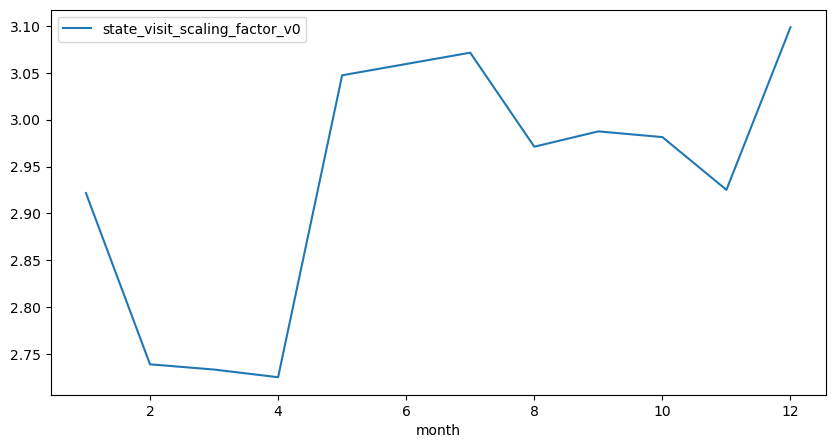

In [329]:
all_county_school_month_df['state_visit_scaling_factor_v0'] = all_county_school_month_df.groupby(['year', 'month', 'state_name'])['raw_visitor_counts'].transform('sum')  /all_county_school_month_df.groupby(['year', 'month', 'state_name'])['noon_visit_80quantile'].transform('sum')
all_county_school_month_df[['state_visit_scaling_factor_v0']]
all_county_school_month_df.query("county_fips == '01103'").plot(x='month', y=[   'state_visit_scaling_factor_v0'], figsize=(10, 5))
# all_county_school_month_df.query("state_name == 'Alabama' and month == 6")
all_county_school_month_df.query("county_fips == '01103'")

<Axes: xlabel='month'>

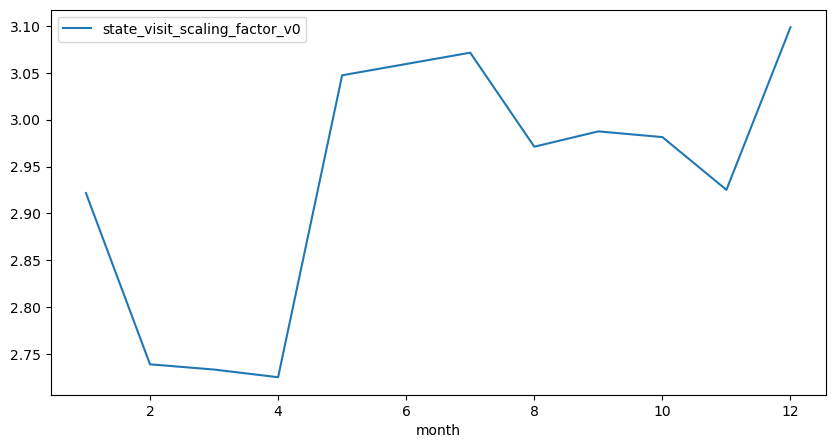

In [319]:
all_county_school_month_df['state_visit_scaling_factor_v0'] = all_county_school_month_df.groupby(['year', 'month', 'state_name'])['raw_visitor_counts'].transform('sum')  /all_county_school_month_df.groupby(['year', 'month', 'state_name'])['noon_visit_80quantile'].transform('sum')
all_county_school_month_df[['state_visit_scaling_factor_v0']]
all_county_school_month_df.query("county_fips == '01103'").plot(x='month', y=[ 'state_visit_scaling_factor_v0'], figsize=(10, 5))

In [173]:
all_county_school_month_df
all_county_school_month_df.groupby(['year', 'month', 'state_name'])['raw_visitor_counts'].sum()#.transform('sum')

year  month  state_name   
2022  1      Alabama          404522
             Alaska            11241
             Arizona          304386
             Arkansas         205756
             California       575762
                               ...  
      12     Virginia         592458
             Washington       322737
             West Virginia    110399
             Wisconsin        256086
             Wyoming           17274
Name: raw_visitor_counts, Length: 571, dtype: int64

In [152]:
all_county_school_month_df['state_visit_scaling_factor'] = all_county_school_month_df.groupby('state_name')['raw_visitor_counts'].transform('sum') / all_county_school_month_df.groupby('state_name')['noon_visit_80quantile'].transform('sum')
all_county_school_month_df['state_visit_scaling_factor'] = all_county_school_month_df['state_visit_scaling_factor'].round(3)
# all_county_school_month_df.sample(10)[['state_visit_scaling_factor', 'visit_scaling_factor']]
all_county_school_month_df[['state_visit_scaling_factor', 'visit_scaling_factor']]

,state_visit_scaling_factor,visit_scaling_factor
0,2.894,2.725
1,2.894,2.878
2,2.894,2.610
3,2.894,2.803
4,2.894,2.923
...,...,...
23414,2.619,2.033
23415,2.619,2.562
23416,2.619,2.848
23417,2.619,2.715


In [120]:
all_county_school_month_df['state_visit_scaling_factor'].unique()
all_county_school_month_df

,year,month,noon_visit_80quantile,raw_visitor_counts,schoolday_count,visit_scaling_factor,school_count,state_name,county_name,county_fips,school_names,state_visit_scaling_factor
0,2022,1,1084,2954,13,2.725,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury...",2.894
1,2022,2,3029,8717,43,2.878,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury...",2.894
2,2022,3,5362,13997,58,2.610,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury...",2.894
3,2022,4,5208,14596,60,2.803,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury...",2.894
4,2022,5,3505,10245,40,2.923,4,Alabama,Autauga,01001,"Autauga Academy, Billingsley High Sch, Marbury...",2.894
...,...,...,...,...,...,...,...,...,...,...,...,...
23414,2022,10,150,305,5,2.033,1,Wyoming,Washakie,56043,Worland High School,2.619
23415,2022,11,160,410,5,2.562,1,Wyoming,Washakie,56043,Worland High School,2.619
23416,2022,2,33,94,1,2.848,1,Wyoming,Weston,56045,Newcastle High School,2.619
23417,2022,3,375,1018,11,2.715,1,Wyoming,Weston,56045,Newcastle High School,2.619


In [6]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
county_school_day_df.sort_values(by=['date'])
# day_df
# ranked_week_df
day_df
# ranked_week_df
# county_school_day_df
# ranked_week_df

,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,date_year,...,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,placekey,school_name,county_FIPS,county_name,State_name
0,2022-02-28,1,0,0,30,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,91,253,2022,...,12.0,NaN,12.0,9,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
1,2022-03-01,1,0,0,30,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,91,244,2022,...,8.0,NaN,8.0,9,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
2,2022-03-02,1,0,0,30,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,91,278,2022,...,15.0,NaN,15.0,9,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
3,2022-03-03,1,0,0,30,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,91,231,2022,...,8.0,NaN,8.0,9,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
4,2022-03-04,1,0,0,30,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,91,254,2022,...,5.0,NaN,5.0,9,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2022-11-07,1,0,0,46,2022-11-07 00:00:00-06:00,2022-11-14 00:00:00-06:00,183,507,2022,...,52.0,NaN,52.0,45,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
78,2022-11-08,1,0,0,46,2022-11-07 00:00:00-06:00,2022-11-14 00:00:00-06:00,183,548,2022,...,48.0,NaN,48.0,45,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
79,2022-11-09,1,0,0,46,2022-11-07 00:00:00-06:00,2022-11-14 00:00:00-06:00,183,513,2022,...,72.0,NaN,72.0,45,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas
80,2022-11-10,1,0,0,46,2022-11-07 00:00:00-06:00,2022-11-14 00:00:00-06:00,183,371,2022,...,1.0,NaN,1.0,45,NaN,zzw-222@8sz-yzn-yqf,Poteet H S,48013,Atascosa,Texas


In [ ]:
ranked_week_df

,week_start_year,week,school_day_cnt,total_evening_gathering_cnt,weekend_daytime_gathering_cnt,weekly_raw_visitor_counts,noon_visit_80quantile,date_range_start,date_range_end,total_non_school_visits,...,non_school_visit_to_school_visit_ratio,school_day_evening_gathering_cnt,gathering_peak_visits,gathering_2nd_peak_visits,peak_visit_1st_and_2nd_sum,placekey,school_name,county_FIPS,county_name,State_name
0,2022,1,4,0,0,79,31,2022-01-03 00:00:00-06:00,2022-01-10 00:00:00-06:00,12.0,...,0.01,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
1,2022,3,4,1,0,82,34,2022-01-17 00:00:00-06:00,2022-01-24 00:00:00-06:00,56.0,...,0.06,1.0,17.0,0.0,17,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
2,2022,7,5,2,0,128,37,2022-02-14 00:00:00-06:00,2022-02-21 00:00:00-06:00,129.0,...,0.10,2.0,19.0,18.0,37,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
3,2022,8,4,0,0,73,34,2022-02-21 00:00:00-06:00,2022-02-28 00:00:00-06:00,15.0,...,0.02,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
4,2022,9,5,0,0,88,36,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,40.0,...,0.03,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
5,2022,10,5,0,0,100,35,2022-03-07 00:00:00-06:00,2022-03-14 00:00:00-06:00,21.0,...,0.02,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
6,2022,12,5,0,0,131,44,2022-03-21 00:00:00-06:00,2022-03-28 00:00:00-06:00,72.0,...,0.05,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
7,2022,13,4,1,0,151,50,2022-03-28 00:00:00-06:00,2022-04-04 00:00:00-06:00,40.0,...,0.03,1.0,15.0,0.0,15,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
8,2022,14,5,0,0,130,46,2022-04-04 00:00:00-06:00,2022-04-11 00:00:00-06:00,40.0,...,0.03,0.0,NaN,NaN,0,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida
9,2022,15,4,1,0,113,40,2022-04-11 00:00:00-06:00,2022-04-18 00:00:00-06:00,92.0,...,0.09,1.0,24.0,0.0,24,zzw-222@8gh-psp-rkz,Wewahitchka High School,12045,Gulf,Florida


In [ ]:
county_school_day_df.query("is_school_day == 1").query("month == 1").sort_values(by=['date'])
# county_school_day_df.groupby(['year', 'month']).agg(schoolday_count=('date', 'count')).reset_index()


,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,date_year,week_start_year,school_day_school_hours_visits,school_day_after_hours_visits,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,year,month
0,2022-01-04,1,0,0,56,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,114,466,2022,2022,450.0,16.0,16.0,NaN,16.0,1,NaN,2022,1
171,2022-01-04,1,0,0,31,2022-01-03 00:00:00-06:00,2022-01-10 00:00:00-06:00,79,256,2022,2022,251.0,4.0,4.0,NaN,4.0,1,NaN,2022,1
172,2022-01-05,1,0,0,31,2022-01-03 00:00:00-06:00,2022-01-10 00:00:00-06:00,79,222,2022,2022,219.0,0.0,0.0,NaN,0.0,1,NaN,2022,1
1,2022-01-05,1,0,0,56,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,114,418,2022,2022,412.0,6.0,6.0,NaN,6.0,1,NaN,2022,1
173,2022-01-06,1,0,0,31,2022-01-03 00:00:00-06:00,2022-01-10 00:00:00-06:00,79,237,2022,2022,235.0,1.0,1.0,NaN,1.0,1,NaN,2022,1
2,2022-01-06,1,1,0,56,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,114,486,2022,2022,443.0,42.0,42.0,NaN,42.0,1,NaN,2022,1
174,2022-01-07,1,0,0,31,2022-01-03 00:00:00-06:00,2022-01-10 00:00:00-06:00,79,230,2022,2022,227.0,0.0,0.0,NaN,0.0,1,NaN,2022,1
3,2022-01-07,1,0,0,56,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,114,424,2022,2022,421.0,2.0,2.0,NaN,2.0,1,NaN,2022,1
175,2022-01-10,1,0,0,60,2022-01-10 00:00:00-06:00,2022-01-17 00:00:00-06:00,198,241,2022,2022,239.0,1.0,1.0,NaN,1.0,2,NaN,2022,1
4,2022-01-10,1,0,0,59,2022-01-10 00:00:00-05:00,2022-01-17 00:00:00-05:00,127,460,2022,2022,448.0,12.0,12.0,NaN,12.0,2,NaN,2022,1


In [ ]:

     
    grouped_county_df = ranked_week_df.groupby(['week_start_year', 'week', 
                                                'date_range_start', 
                                                'date_range_end', 
                                                'county_FIPS', 
                                                'county_name', 
                                                'State_name']).agg(
        noon_visit_80quantile=('noon_visit_80quantile', 'sum'),
        weekly_raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
        school_count=('placekey', 'nunique')
                                                ).reset_index()
    
    grouped_county_df['visit_scaling_factor'] = grouped_county_df['weekly_raw_visitor_counts'] / grouped_county_df['noon_visit_80quantile']
    grouped_county_df['visit_scaling_factor'] = grouped_county_df['visit_scaling_factor'].round(2)

    days_files = files_df.query(f"county_fips == '{county_fips}'")['day_file_path'].tolist()
    days_files.sort()
    print("Found day files:", len(days_files))
    
    df_list = []
    for day_file in days_files:
        day_df = pd.read_csv(day_file)
        day_df['file_name'] = os.path.basename(day_file)
        df_list.append(day_df)

    if len(df_list) > 0:
        county_school_day_df = pd.concat(df_list)        
    
        county_school_day_df['year'] = pd.to_datetime(county_school_day_df['date']).dt.year
        county_school_day_df['month'] = pd.to_datetime(county_school_day_df['date']).dt.month
        merged_county_school_day_df = county_school_day_df.merge(grouped_county_df[['week_start_year', 'week', 'date_range_start', 'date_range_end' ]])
        county_school_month_df = merged_county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=                      ('noon_visit_80quantile', 'sum'),
                                                                                    raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
                                                                                    schoolday_count=('date', 'nunique'),
                                                                                    ).reset_index()
        county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
        # county_school_month_df = merged_county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=                      ('noon_visit_80quantile', 'sum'),
        #                                                                          raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
        #                                                                          schoolday_count=('date', 'nunique'),
        #                                                                          ).reset_index()
        # county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
        


    break

grouped_county_df
county_school_day_df.sort_values(by=['date'], inplace=True)
county_school_day_df
county_school_month_df
# merged_county_school_day_df
merged_county_school_day_df.query("is_school_day == 1").reset_index().groupby(['year', 'month']).size()
merged_county_school_day_df.sort_values(by=['date']).query("is_school_day == 1")

In [ ]:
# has bugs!!!!!!!!!!!!!!!!!!! 

noon_visit_80quantile_thres = 30

def week_factor_to_month(grouped_county_df):

    pass

for county_fips in tqdm(all_county_fips, total=len(all_county_fips)):
    # county_fips = '01001'  # 2022-04-11 week has issues. high visit_scaling_factor > 5 due to less school data
    # county_fips = random.choice(all_county_fips)
    county_fips = '18071'
    # county_fips = random.choice(all_county_fips)
    county_week_files = files_df.query(f"county_fips == '{county_fips}'")['week_file_name'].tolist()
    county_week_files.sort()

    print("Processing county FIPS:", county_fips)
    print("Found week files:", len(county_week_files))
    
    df_list = []
    for f in county_week_files:
        temp_df = pd.read_csv(f)
        if len(temp_df) > 0:            
            df_list.append(temp_df)
    if len(df_list) > 0:
        ranked_week_df = pd.concat(df_list)
    else:
        print(f'No data found for county FIPS: {county_fips}, skipping...')
        continue

    ranked_week_df['county_FIPS'] = ranked_week_df['county_FIPS'].astype(str).str.zfill(5)     
    ranked_week_df['weekly_raw_visitor_counts'] = ranked_week_df['weekly_raw_visitor_counts'].astype(int)
    ranked_week_df['noon_visit_80quantile'] = ranked_week_df['noon_visit_80quantile'].astype(int)
    ranked_week_df = ranked_week_df.query(f"noon_visit_80quantile >= {noon_visit_80quantile_thres}")
      
    grouped_county_df = ranked_week_df.groupby(['week_start_year', 'week', 
                                                'date_range_start', 
                                                'date_range_end', 
                                                'county_FIPS', 
                                                'county_name', 
                                                'State_name']).agg(
        noon_visit_80quantile=('noon_visit_80quantile', 'sum'),
        weekly_raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
        school_count=('placekey', 'nunique')
                                                ).reset_index()
    
    grouped_county_df['visit_scaling_factor'] = grouped_county_df['weekly_raw_visitor_counts'] / grouped_county_df['noon_visit_80quantile']
    grouped_county_df['visit_scaling_factor'] = grouped_county_df['visit_scaling_factor'].round(2)

    days_files = files_df.query(f"county_fips == '{county_fips}'")['day_file_path'].tolist()
    days_files.sort()
    print("Found day files:", len(days_files))
    
    df_list = []
    for day_file in days_files:
        day_df = pd.read_csv(day_file)
        day_df['file_name'] = os.path.basename(day_file)
        df_list.append(day_df)

    if len(df_list) > 0:
        county_school_day_df = pd.concat(df_list)        
    
        county_school_day_df['year'] = pd.to_datetime(county_school_day_df['date']).dt.year
        county_school_day_df['month'] = pd.to_datetime(county_school_day_df['date']).dt.month
        merged_county_school_day_df = county_school_day_df.merge(grouped_county_df[['week_start_year', 'week', 'date_range_start', 'date_range_end' ]])
        county_school_month_df = merged_county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=                      ('noon_visit_80quantile', 'sum'),
                                                                                    raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
                                                                                    schoolday_count=('date', 'nunique'),
                                                                                    ).reset_index()
        county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
        # county_school_month_df = merged_county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=                      ('noon_visit_80quantile', 'sum'),
        #                                                                          raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
        #                                                                          schoolday_count=('date', 'nunique'),
        #                                                                          ).reset_index()
        # county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
        


    break

grouped_county_df
county_school_day_df.sort_values(by=['date'], inplace=True)
county_school_day_df
county_school_month_df
# merged_county_school_day_df
merged_county_school_day_df.query("is_school_day == 1").reset_index().groupby(['year', 'month']).size()
merged_county_school_day_df.sort_values(by=['date']).query("is_school_day == 1")

  0%|          | 0/2678 [00:00<?, ?it/s]

Processing county FIPS: 18071
Found week files: 2
Found day files: 2


,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,date_year,...,school_day_school_hours_visits,school_day_after_hours_visits,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,file_name,year,month
238,2022-01-03,1,0,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,249,2022,...,217.0,29.0,29.0,NaN,29.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
1,2022-01-04,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,2022,...,189.0,11.0,11.0,NaN,11.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
239,2022-01-04,1,1,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,520,2022,...,205.0,307.0,307.0,NaN,307.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
2,2022-01-05,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,2022,...,200.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
240,2022-01-05,1,0,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,236,2022,...,177.0,57.0,57.0,NaN,57.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2022-12-14,1,0,0,58,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,142,239,2022,...,236.0,3.0,3.0,NaN,3.0,50,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,12
472,2022-12-15,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,193,2022,...,179.0,11.0,11.0,NaN,11.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
234,2022-12-15,1,0,0,58,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,142,245,2022,...,245.0,0.0,0.0,NaN,0.0,50,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,12
473,2022-12-16,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,178,2022,...,167.0,5.0,5.0,NaN,5.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12


In [ ]:
merged_county_school_day_df.query("is_school_day == 1").reset_index()

,index,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,...,school_day_school_hours_visits,school_day_after_hours_visits,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,file_name,year,month
0,1,2022-01-04,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,...,189.0,11.0,11.0,NaN,11.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
1,2,2022-01-05,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,...,200.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
2,3,2022-01-06,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,208,...,206.0,2.0,2.0,NaN,2.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
3,4,2022-01-07,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,185,...,185.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
4,7,2022-01-10,1,0,0,38,2022-01-10 00:00:00-05:00,2022-01-17 00:00:00-05:00,111,163,...,163.0,0.0,0.0,NaN,0.0,2,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,469,2022-12-12,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,259,...,222.0,35.0,35.0,NaN,35.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
323,470,2022-12-13,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,259,...,226.0,26.0,26.0,NaN,26.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
324,471,2022-12-14,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,322,...,234.0,86.0,86.0,NaN,86.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
325,472,2022-12-15,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,193,...,179.0,11.0,11.0,NaN,11.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12


In [ ]:
county_school_day_df
day_df
ranked_week_df

,week_start_year,week,school_day_cnt,total_evening_gathering_cnt,weekend_daytime_gathering_cnt,weekly_raw_visitor_counts,noon_visit_80quantile,date_range_start,date_range_end,total_non_school_visits,...,non_school_visit_to_school_visit_ratio,school_day_evening_gathering_cnt,gathering_peak_visits,gathering_2nd_peak_visits,peak_visit_1st_and_2nd_sum,placekey,school_name,county_FIPS,county_name,State_name
0,2022,1,4,0,0,97,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,15.0,...,0.02,0.0,NaN,NaN,0,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
1,2022,2,5,1,0,111,38,2022-01-10 00:00:00-05:00,2022-01-17 00:00:00-05:00,61.0,...,0.07,0.0,17.0,0.0,17,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
2,2022,3,4,1,0,134,36,2022-01-17 00:00:00-05:00,2022-01-24 00:00:00-05:00,78.0,...,0.12,1.0,27.0,0.0,27,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
3,2022,4,5,0,0,108,41,2022-01-24 00:00:00-05:00,2022-01-31 00:00:00-05:00,33.0,...,0.04,0.0,NaN,NaN,0,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
4,2022,6,5,1,0,142,43,2022-02-07 00:00:00-05:00,2022-02-14 00:00:00-05:00,101.0,...,0.11,1.0,24.0,0.0,24,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
5,2022,7,5,1,0,151,48,2022-02-14 00:00:00-05:00,2022-02-21 00:00:00-05:00,98.0,...,0.10,0.0,27.0,0.0,27,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
6,2022,8,4,0,0,98,43,2022-02-21 00:00:00-05:00,2022-02-28 00:00:00-05:00,15.0,...,0.02,0.0,NaN,NaN,0,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
7,2022,9,5,1,0,115,39,2022-02-28 00:00:00-05:00,2022-03-07 00:00:00-05:00,51.0,...,0.05,1.0,13.0,0.0,13,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
8,2022,10,5,0,0,126,53,2022-03-07 00:00:00-05:00,2022-03-14 00:00:00-05:00,21.0,...,0.02,0.0,NaN,NaN,0,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana
9,2022,11,5,1,0,124,53,2022-03-14 00:00:00-05:00,2022-03-21 00:00:00-05:00,46.0,...,0.04,1.0,15.0,0.0,15,222-222@5py-9yy-cqz,Brownstown Central High Sch,18071,Jackson,Indiana


In [ ]:
county_school_day_df.query("is_school_day == True").sort_values(by=['date'])

,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,date_year,...,school_day_school_hours_visits,school_day_after_hours_visits,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,file_name,year,month
0,2022-01-03,1,0,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,249,2022,...,217.0,29.0,29.0,NaN,29.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
1,2022-01-04,1,1,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,520,2022,...,205.0,307.0,307.0,NaN,307.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
1,2022-01-04,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,2022,...,189.0,11.0,11.0,NaN,11.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
2,2022-01-05,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,2022,...,200.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
2,2022-01-05,1,0,0,24,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,180,236,2022,...,177.0,57.0,57.0,NaN,57.0,1,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,2022-12-16,1,0,0,58,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,142,227,2022,...,227.0,0.0,0.0,NaN,0.0,50,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,12
350,2022-12-19,1,0,0,46,2022-12-19 00:00:00-05:00,2022-12-26 00:00:00-05:00,118,229,2022,...,228.0,1.0,1.0,NaN,1.0,51,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,12
351,2022-12-20,1,0,0,46,2022-12-19 00:00:00-05:00,2022-12-26 00:00:00-05:00,118,245,2022,...,245.0,0.0,0.0,NaN,0.0,51,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,12
353,2022-12-22,1,0,0,13,2022-12-19 00:00:00-05:00,2022-12-26 00:00:00-05:00,137,150,2022,...,140.0,4.0,4.0,NaN,4.0,51,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12


In [ ]:
merged_county_school_day_df.query("is_school_day == 1").reset_index()

,index,date,is_school_day,has_evening_gathering,has_weekend_daytime_gathering,noon_visit_80quantile,date_range_start,date_range_end,weekly_raw_visitor_counts,total_daily_visits,...,school_day_school_hours_visits,school_day_after_hours_visits,afterschool_visits,weekend_visits,total_non_school_visits,week,weekend_day_has_evening_gathering,file_name,year,month
0,1,2022-01-04,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,...,189.0,11.0,11.0,NaN,11.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
1,2,2022-01-05,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,201,...,200.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
2,3,2022-01-06,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,208,...,206.0,2.0,2.0,NaN,2.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
3,4,2022-01-07,1,0,0,44,2022-01-03 00:00:00-05:00,2022-01-10 00:00:00-05:00,97,185,...,185.0,0.0,0.0,NaN,0.0,1,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
4,7,2022-01-10,1,0,0,38,2022-01-10 00:00:00-05:00,2022-01-17 00:00:00-05:00,111,163,...,163.0,0.0,0.0,NaN,0.0,2,NaN,Indiana_Jackson_18071_Brownstown Central High ...,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,469,2022-12-12,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,259,...,222.0,35.0,35.0,NaN,35.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
323,470,2022-12-13,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,259,...,226.0,26.0,26.0,NaN,26.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
324,471,2022-12-14,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,322,...,234.0,86.0,86.0,NaN,86.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12
325,472,2022-12-15,1,0,0,27,2022-12-12 00:00:00-05:00,2022-12-19 00:00:00-05:00,169,193,...,179.0,11.0,11.0,NaN,11.0,50,NaN,Indiana_Jackson_18071_Trinity Lutheran High Sc...,2022,12


In [ ]:

county_school_month_df = merged_county_school_day_df.query("is_school_day == 1").groupby(['year', 'month']).agg(noon_visit_80quantile=('noon_visit_80quantile', 'sum'),
                                                                                 raw_visitor_counts=('weekly_raw_visitor_counts', 'sum'),
                                                                                 data_day=('date', 'nunique'),
                                                                                 ).reset_index()
county_school_month_df['visit_scaling_factor'] = county_school_month_df['raw_visitor_counts'] / county_school_month_df['noon_visit_80quantile']
county_school_month_df

,year,month,noon_visit_80quantile,raw_visitor_counts,data_day,visit_scaling_factor
0,2022,1,2281,8095,14,3.548882
1,2022,2,1123,4144,6,3.690116
2,2022,3,3707,11369,18,3.066900
3,2022,4,4078,11715,19,2.872732
4,2022,5,3555,10360,20,2.914205
5,2022,8,2690,8312,13,3.089963
6,2022,9,4187,14022,20,3.348937
7,2022,10,4258,12000,20,2.818225
8,2022,11,2036,5543,9,2.722495
9,2022,12,1175,4815,5,4.097872


In [ ]:
grouped_county_df[['visit_scaling_factor']].describe()

,visit_scaling_factor
count,25.000000
mean,2.238400
std,0.218531
min,1.840000
25%,2.070000
50%,2.260000
75%,2.370000
max,2.730000


In [ ]:
grouped_county_df
 

,week_start_year,week,date_range_start,date_range_end,county_FIPS,county_name,State_name,noon_visit_80quantile,weekly_raw_visitor_counts,school_count,visit_scaling_factor
0,2022,2,2022-01-10 00:00:00-06:00,2022-01-17 00:00:00-06:00,21047,Christian,Kentucky,164,381,2,2.32
1,2022,4,2022-01-24 00:00:00-06:00,2022-01-31 00:00:00-06:00,21047,Christian,Kentucky,167,390,2,2.34
2,2022,6,2022-02-07 00:00:00-06:00,2022-02-14 00:00:00-06:00,21047,Christian,Kentucky,184,428,2,2.33
3,2022,7,2022-02-14 00:00:00-06:00,2022-02-21 00:00:00-06:00,21047,Christian,Kentucky,217,533,3,2.46
4,2022,9,2022-02-28 00:00:00-06:00,2022-03-07 00:00:00-06:00,21047,Christian,Kentucky,233,554,3,2.38
5,2022,10,2022-03-07 00:00:00-06:00,2022-03-14 00:00:00-06:00,21047,Christian,Kentucky,268,688,3,2.57
6,2022,11,2022-03-14 00:00:00-06:00,2022-03-21 00:00:00-06:00,21047,Christian,Kentucky,230,498,2,2.17
7,2022,12,2022-03-21 00:00:00-06:00,2022-03-28 00:00:00-06:00,21047,Christian,Kentucky,232,514,2,2.22
8,2022,13,2022-03-28 00:00:00-06:00,2022-04-04 00:00:00-06:00,21047,Christian,Kentucky,306,926,4,3.03
9,2022,15,2022-04-11 00:00:00-06:00,2022-04-18 00:00:00-06:00,21047,Christian,Kentucky,319,974,4,3.05
